In [1]:
import os
import glob
import random
import torch
import numpy as np
import pickle as pk
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import SimpleITK as sitk
import nibabel as nb
from scipy.ndimage.interpolation import zoom
import time

In [2]:
rootFolder = 'C:\\Users\\sm5797\\Documents\\CochleaRIT'

In [27]:
def combineMasks(ST, SM, SV):
    STmask = np.where(ST>10., 1., 0.)
    SMmask = np.where(SM>10., 2., 0.)
    SVmask = np.where(SV>10., 3., 0.)
    
    combineTemp = STmask + SMmask
    combineTemp = np.where(combineTemp==3, 1, combineTemp)
    
    finMask = combineTemp + SVmask
    finMask = np.where(finMask==4, 1, finMask)
    finMask = np.where(finMask==5, 2, finMask)
    
    return finMask

def rszForModel(vol):
    rszScan = []
    finScan = []
    t1 = time.time()
    for i in range(vol.shape[2]):
        slc = vol[:,:,i]
        rszSlc = cv2.resize(slc, (256,256))
        rszScan.append(rszSlc)
    rszScan = np.array(rszScan)
        
    for j in range(rszScan.shape[2]):
        slc2 = rszScan[:,:,j]
        rszSlc2 = cv2.resize(slc2, (256,256))
        finScan.append(rszSlc2)
    finScan = np.array(finScan)
    t2 = time.time() - t1
    print('time taken to do interpolation: ',t2)
    
    '''
    volSz = vol.shape
    scale = tuple([256/x for x in volSz])
    t1 = time.time()
    rszVol = zoom(vol, zoom=scale)
    t2 = time.time() - t1
    print('time taken to do interpolation: ',t2)
    '''
    
    return finScan.transpose((2,0,1)) #rszVol

In [28]:
class CochleaRIT(Dataset):

    #def __init__(self, dataPartition, dataPath, transform=None):
    def __init__(self, dataPath, transform=None):
        self.dataPath = dataPath
        self.dataList = []
        for foldr in os.listdir(self.dataPath):
            self.dataList.append(os.path.join(self.dataPath, foldr))
        #self.dataPartition = dataPartition
        self.transform = transform

    def __len__(self):
        return len(self.dataList)

    def __getitem__(self, img_id):
        #imgID = self.dataList[img_id]
        imagePath = os.path.join(self.dataList[img_id], 'ear.nii')
        STPath = os.path.join(self.dataList[img_id], 'ST_labelmap.nii')
        SMPath = os.path.join(self.dataList[img_id], 'SM_labelmap.nii')
        SVPath = os.path.join(self.dataList[img_id], 'SV_labelmap.nii')
        
        img = nb.load(imagePath)
        scan = img.get_fdata()
        scan = rszForModel(scan)
        scan = scan.astype(np.uint8)
        
        lm1 = nb.load(STPath)
        lm2 = nb.load(SMPath)
        lm3 = nb.load(SVPath)
        
        ST_temp = lm1.get_fdata()
        SM_temp = lm2.get_fdata()
        SV_temp = lm3.get_fdata()
        
        ST_temp = rszForModel(ST_temp)
        SM_temp = rszForModel(SM_temp)
        SV_temp = rszForModel(SV_temp)
        
        finalMask = combineMasks(ST_temp, SM_temp, SV_temp).astype(np.uint8)
        scan = np.divide(scan, 255.)

        dataDict = {'scan': scan, 'mask': finalMask}

        if self.transform:
            dataDict = self.transform(dataDict)

        return dataDict

In [29]:
class Augmentations(object):
    def __init__(self, dataPartition, alpha, enable=None):
        self.dataPartition = dataPartition
        self.alpha = alpha
        self.enable = enable
        
    def __call__(self, dataDict):
        if self.enable:
            scan_, mask_ = dataDict['scan'], dataDict['mask']
            tx = ElasticTransform(p=1, alpha=self.alpha, sigma=self.alpha * 0.05, alpha_affine=self.alpha * 0.03)

            txdDataSample = tx(image=scan_, mask=mask_)

            elasticScan = txdDataSample['scan']
            elasticMask = txdDataSample['mask']

            elasticScan = elasticScan[np.newaxis, ...]
            elasticMask = elasticMask[np.newaxis, ...]
            dataDict = {'scan': elasticScan, 'mask': elasticMask}

        else:
            scan_, mask_ = dataDict['scan'], dataDict['mask']
            
            noTxScan = scan_[np.newaxis, ...]
            noTxMask = mask_[np.newaxis, ...]
            dataDict = {'scan': noTxScan, 'mask': noTxMask}

        return dataDict

In [30]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        scan_, mask_ = sample['scan'], sample['mask']

        # swap color axis because
        # numpy image: H x W x D x C
        # torch image: C x H x W x D
        scan_ = scan_.transpose((0, 3, 1, 2))
        mask_ = mask_.transpose((0, 3, 1, 2))
        tempImg = torch.from_numpy(scan_)
        tempMsk = torch.from_numpy(mask_)

        tempImg = tempImg.type(torch.FloatTensor)
        tempMsk = tempMsk.type(torch.FloatTensor)
        return {'scan': tempImg, 'mask': tempMsk}

In [31]:
#train = CochleaRIT(rootFolder, transform=transforms.Compose([Augmentations('train',120,False), ToTensor()]))
train = CochleaRIT(rootFolder)

In [32]:
im1 = train.__getitem__(0)

time taken to do interpolation:  0.31885695457458496
time taken to do interpolation:  0.31885600090026855
time taken to do interpolation:  0.3183562755584717
time taken to do interpolation:  0.327378511428833


In [33]:
print(im1['scan'].max())

0.9921568627450981


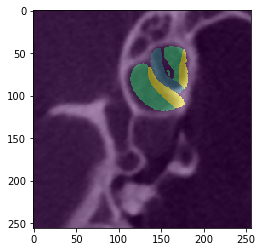

In [38]:
import matplotlib.pyplot as plt
plt.imshow(im1['scan'][:,:,200], cmap='gray')
plt.imshow(im1['mask'][:,:,200], alpha=0.5)

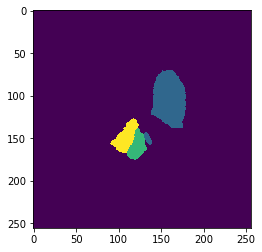

In [36]:
plt.imshow(im1['mask'][:,:,100])

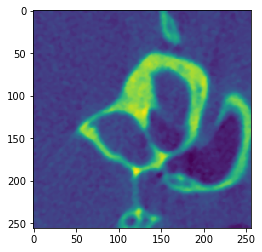

In [37]:
plt.imshow(im1['scan'][:,:,100])